In [34]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE
import itertools
import time
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import cross_val_score
from tabulate import tabulate
import optuna
from joblib import dump
from joblib import load



#### Data Loading and Initial Exploration


In [35]:
# load Train data
train_data = pd.read_csv('Dataset/Train_data.csv')
# load Test data
test_data = pd.read_csv('Dataset/Test_data.csv')


In [36]:
# we will use the following features to train our model
train_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [37]:
# we will use the following features to test our model
test_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,private,REJ,0,0,0,0,0,0,...,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00
1,0,tcp,private,REJ,0,0,0,0,0,0,...,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71


In [38]:
# General information and statistics about the train data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [39]:
# describe the train data
train_data.describe(include='object')

,protocol_type,service,flag,class
count,25192,25192,25192,25192
unique,3,66,11,2
top,tcp,http,SF,normal
freq,20526,8003,14973,13449


In [40]:
train_data.protocol_type.unique()

array(['tcp', 'udp', 'icmp'], dtype=object)

#### Data Cleaning and Preprocessing

In [41]:
# Checking for missing values and duplicates
missing_values = train_data.isnull().sum()
total = train_data.shape[0]
missing_columns = [col for col in train_data.columns if train_data[col].isnull().sum() > 0]
for col in missing_columns:
    null_count = train_data[col].isnull().sum()
    per = (null_count/total) * 100
    print(f"{col}: {null_count} ({round(per, 3)}%)")

In [42]:
# Checking for duplicate rows
print(f"Number of duplicate rows: {train_data.duplicated().sum()}")

Number of duplicate rows: 0


<AxesSubplot:xlabel='class', ylabel='count'>

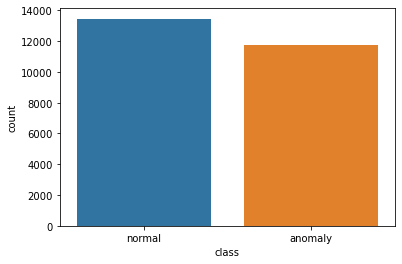

In [43]:
# Class distribution in Training set

sns.countplot(x=train_data['class'])

In [44]:
print('Class distribution Training set:')
print(train_data['class'].value_counts())

Class distribution Training set:
normal     13449
anomaly    11743
Name: class, dtype: int64


In [45]:
# Encoding categorical features
def label_encode(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            label_encoder = LabelEncoder()
            df[col] = label_encoder.fit_transform(df[col])

label_encode(train_data)
label_encode(test_data)


In [46]:
# why drop this column?
# The column num_outbound_cmds has only one unique value, so it is not useful for our model
train_data.drop(['num_outbound_cmds'], axis=1, inplace=True)
test_data.drop(['num_outbound_cmds'], axis=1, inplace=True)
# drop hot column
train_data.drop(['hot'], axis=1, inplace=True)
test_data.drop(['hot'], axis=1, inplace=True)

#### Feature Selection and Normalization

In [47]:
# Splitting data into features and target
X_train = train_data.drop(['class'], axis=1)
Y_train = train_data['class']

In [48]:
# What is happening in this code
# Random Forest Classifier is used to rank the importance of features
# RFE is used to select the most important features
# we will use 5 features in our model
# we will use the selected features to train our model
# we will use the selected features to test our model

# Feature selection using Random Forest Classifier
rfc = DecisionTreeClassifier()  # Using Decision Tree for feature selection
rfe = RFE(rfc, n_features_to_select=5)
rfe = rfe.fit(X_train, Y_train)

# Selecting important features
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i==True]
selected_features

['protocol_type',
 'src_bytes',
 'dst_bytes',
 'dst_host_srv_count',
 'dst_host_same_srv_rate']

In [49]:
# Train data with selected features
X_train = X_train[selected_features]

In [50]:
# Scaling features why? and what is the purpose of scaling?
# Scaling is used to standardize the range of independent variables or features of the data
# StandardScaler is used to scale the features
# we will use the scaled features to train our model
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
test = scale.fit_transform(test_data)


In [51]:

# Splitting the dataset for training and testing
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=42)

#### Decision Tree Model Training and Tuning

In [52]:

# Training a basic Decision Tree Classifier
# Time to train the model
clfd = DecisionTreeClassifier(criterion ="entropy", max_depth = 4)
start_time = time.time()
clfd.fit(x_train, y_train.values.ravel())
end_time = time.time()
print("Training time: ", end_time-start_time)

Training time:  0.0165708065032959


In [53]:
# Time taken to test the model
start_time = time.time()
y_test_pred = clfd.predict(x_train)
end_time = time.time()
print("Testing time: ", end_time-start_time)

Testing time:  0.002251148223876953


In [54]:

# Hyperparameter Tuning for Decision Tree using Optuna
def objective(trial):
    dt_max_depth = trial.suggest_int('dt_max_depth', 2, 32, log=False)
    dt_max_features = trial.suggest_int('dt_max_features', 2, 5, log=False)
    classifier_obj = DecisionTreeClassifier(max_features=dt_max_features, max_depth=dt_max_depth)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy


In [55]:
# start the optimization process
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective, n_trials=30)
print(study_dt.best_trial)

[I 2024-02-05 18:51:26,146] A new study created in memory with name: no-name-a937db0d-2399-4729-9e89-33a33e68d46c
[I 2024-02-05 18:51:26,166] Trial 0 finished with value: 0.991002910822969 and parameters: {'dt_max_depth': 24, 'dt_max_features': 2}. Best is trial 0 with value: 0.991002910822969.
[I 2024-02-05 18:51:26,190] Trial 1 finished with value: 0.9941783540619211 and parameters: {'dt_max_depth': 21, 'dt_max_features': 4}. Best is trial 1 with value: 0.9941783540619211.
[I 2024-02-05 18:51:26,199] Trial 2 finished with value: 0.9354326541413073 and parameters: {'dt_max_depth': 3, 'dt_max_features': 2}. Best is trial 1 with value: 0.9941783540619211.
[I 2024-02-05 18:51:26,220] Trial 3 finished with value: 0.9940460439269648 and parameters: {'dt_max_depth': 12, 'dt_max_features': 3}. Best is trial 1 with value: 0.9941783540619211.
[I 2024-02-05 18:51:26,250] Trial 4 finished with value: 0.9949722148716592 and parameters: {'dt_max_depth': 15, 'dt_max_features': 5}. Best is trial 4 w

FrozenTrial(number=20, state=TrialState.COMPLETE, values=[0.9951045250066155], datetime_start=datetime.datetime(2024, 2, 5, 18, 51, 26, 680920), datetime_complete=datetime.datetime(2024, 2, 5, 18, 51, 26, 712130), params={'dt_max_depth': 15, 'dt_max_features': 4}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dt_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'dt_max_features': IntDistribution(high=5, log=False, low=2, step=1)}, trial_id=20, value=None)


In [56]:

# Training the Decision Tree model with the best parameters
dt = DecisionTreeClassifier(max_features=study_dt.best_trial.params['dt_max_features'], max_depth=study_dt.best_trial.params['dt_max_depth'])
dt.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=15, max_features=4)

#### Model Evaluation

In [57]:
# Model Performance Metrics
dt_train, dt_test = dt.score(x_train, y_train), dt.score(x_test, y_test)
print(f"Train Score: {dt_train}")
print(f"Test Score: {dt_test}")


Train Score: 0.9984121583304979
Test Score: 0.9939137337920084


In [58]:

# Cross-Validation why we use cross-validation?
# Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.
# The goal of cross-validation is to test the model’s ability to predict new data that was not used in estimating it
# we will use cross-validation to evaluate the performance of our model
# we will use 10 folds for cross-validation
# we will use the accuracy metric to evaluate the performance of our model

scores = cross_val_score(dt, x_train, y_train, cv=10, scoring='accuracy')
print(f"Cross-Validation Accuracy: {np.mean(scores)}")

Cross-Validation Accuracy: 0.9924576807467173


In [59]:
# Confusion Matrix and Classification Report why we use these metrics?
# Confusion matrix is used to evaluate the performance of a classification model
# Classification report is used to measure the quality of predictions from a classification algorithm
y_pred = dt.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

[[3498   18]
 [  28 4014]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3516
           1       1.00      0.99      0.99      4042

    accuracy                           0.99      7558
   macro avg       0.99      0.99      0.99      7558
weighted avg       0.99      0.99      0.99      7558

F1 Score: 0.994302700024771


#### Summary Table

In [60]:

# Creating a summary table of model performance
data = [["Decision Tree", dt_train, dt_test, np.mean(scores), f1]]
col_names = ["Model", "Train Score", "Test Score", "CV Accuracy", "F1 Score"]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═══════════════╤═══════════════╤══════════════╤═══════════════╤════════════╕
│ Model         │   Train Score │   Test Score │   CV Accuracy │   F1 Score │
╞═══════════════╪═══════════════╪══════════════╪═══════════════╪════════════╡
│ Decision Tree │      0.998412 │     0.993914 │      0.992458 │   0.994303 │
╘═══════════════╧═══════════════╧══════════════╧═══════════════╧════════════╛


#### Saving the model

In [61]:
# Save the model to a file
model_filename = 'decision_tree_model.joblib'
dump(dt, model_filename)
print(f"Model saved to {model_filename}")

Model saved to decision_tree_model.joblib


#### Load the model

In [62]:
# Load the model from the file
loaded_model = load(model_filename)
print("Model loaded successfully")

Model loaded successfully


In [64]:
from scapy.all import IP, TCP, UDP, sniff
import numpy as np
import joblib
from collections import defaultdict, Counter

def encode_protocol(packet):
    protocol_mapping = {'icmp': 0, 'tcp': 1, 'udp': 2}
    if IP in packet:
        if packet[IP].proto == 1:
            return protocol_mapping['icmp']
        elif packet[IP].proto == 6:
            return protocol_mapping['tcp']
        elif packet[IP].proto == 17:
            return protocol_mapping['udp']
    return -1

class ConnectionTracker:
    def __init__(self):
        self.connections = defaultdict(lambda: {'src_bytes': 0, 'dst_bytes': 0, 'dst_host_srv_count': 0, 'dst_host_same_srv_rate': 0})
        self.dst_host_counts = Counter()

    def update_connection(self, packet):
        if IP in packet and (TCP in packet or UDP in packet):
            src = (packet[IP].src, packet[TCP].sport if TCP in packet else packet[UDP].sport)
            dst = (packet[IP].dst, packet[TCP].dport if TCP in packet else packet[UDP].dport)
            key = src + dst

            if packet[IP].src == src[0]:
                self.connections[key]['src_bytes'] += len(packet)
            else:
                self.connections[key]['dst_bytes'] += len(packet)

            # Update counts for dst_host_srv_count
            self.dst_host_counts[dst] += 1
            for conn_key in self.connections:
                if conn_key[2:] == dst:
                    self.connections[conn_key]['dst_host_srv_count'] = self.dst_host_counts[dst]

            # Calculate dst_host_same_srv_rate
            total_connections_to_dst_host = sum(1 for k in self.connections if k[2] == dst[0])
            if total_connections_to_dst_host > 0:
                same_srv_rate = self.dst_host_counts[dst] / total_connections_to_dst_host
                for conn_key in self.connections:
                    if conn_key[2] == dst[0]:
                        self.connections[conn_key]['dst_host_same_srv_rate'] = same_srv_rate

class NetworkTrafficAnalysis:
    def __init__(self, model_path):
        self.model = joblib.load(model_path)
        self.tracker = ConnectionTracker()

    def process_packet(self, packet):
        if IP not in packet:
            return
        
        protocol_type = encode_protocol(packet)
        self.tracker.update_connection(packet)
        
        for key, stats in self.tracker.connections.items():
            features = np.array([[protocol_type, stats['src_bytes'], stats['dst_bytes'], stats['dst_host_srv_count'], stats['dst_host_same_srv_rate']]])
            prediction = self.model.predict(features)[0]
            traffic_type = "Anomaly/Attack" if prediction == 1 else "Normal"
            print(f"Connection: {key}, Traffic Classification: {traffic_type}, " +
                  f"Features: protocol_type={protocol_type}, src_bytes={stats['src_bytes']}, " +
                  f"dst_bytes={stats['dst_bytes']}, dst_host_srv_count={stats['dst_host_srv_count']}, " +
                  f"dst_host_same_srv_rate={stats['dst_host_same_srv_rate']}")

    def start_capture(self):
        print("Starting packet capture. Press Ctrl+C to stop.")
        sniff(prn=self.process_packet, store=False)

if __name__ == "__main__":
    model_path = 'decision_tree_model.joblib'
    analysis_system = NetworkTrafficAnalysis(model_path)
    analysis_system.start_capture()


Starting packet capture. Press Ctrl+C to stop.
Connection: ('139.64.36.178', 50040, '172.20.10.4', 50041), Traffic Classification: Normal, Features: protocol_type=2, src_bytes=122, dst_bytes=0, dst_host_srv_count=1, dst_host_same_srv_rate=1.0
Connection: ('139.64.36.178', 50040, '172.20.10.4', 50041), Traffic Classification: Normal, Features: protocol_type=2, src_bytes=122, dst_bytes=0, dst_host_srv_count=1, dst_host_same_srv_rate=1.0
Connection: ('172.20.10.4', 50013, '139.64.36.178', 50008), Traffic Classification: Normal, Features: protocol_type=2, src_bytes=150, dst_bytes=0, dst_host_srv_count=1, dst_host_same_srv_rate=1.0
Connection: ('139.64.36.178', 50040, '172.20.10.4', 50041), Traffic Classification: Normal, Features: protocol_type=2, src_bytes=122, dst_bytes=0, dst_host_srv_count=1, dst_host_same_srv_rate=0.5
Connection: ('172.20.10.4', 50013, '139.64.36.178', 50008), Traffic Classification: Normal, Features: protocol_type=2, src_bytes=150, dst_bytes=0, dst_host_srv_count=1, 